## Rohlik orders forecasts
This notebook contains a time series forecasting task with Rohlik dataset EDA and data preprocessing and as an engine using LSTM model with Tensorflow 2 backend. 

<br><b>Approach:</b>
<br>As Rohlík orders dataset contains data from multiple warehouses, thus it contains multiple timelines, the approach is to process and predict each warehouse as a separate timeline. The preprocessing, fiting and evaluation steps are the same for each warehouse.

<br>This approach yields very good MAPE value, which is calculated as a mean of all warehouse timeline results.

In [1]:
! pip -q install pandas matplotlib numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate


TIME_STEPS = 56
EPOCHS = 100
BATCH_SIZE = 32
WAREHOUSE = "None" # For testing purposes

# Temporal features
#LAG_DAYS = [7, 28, 56, 84, 168, 364]
#ROLLING_WINDOW = [28, 168, 364]
LAG_DAYS = [56, 84, 168, 364]
ROLLING_WINDOW = [56, 168, 364]

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'school_holidays', 'frankfurt_shutdown', 'blackout', 'holiday', 'shutdown', 'winter_school_holidays', 'mov_change', 'holiday_name', 'date', 'mini_shutdown', 'shops_closed', 'precipitation', 'snow', 'warehouse'}
No differences found in column: school_holidays
No differences found in column: frankfurt_shutdown
No differences found in column: blackout
No differences found in column: holiday
No differences found in column: shutdown
No differences found in column: winter_school_holidays
No differences found in column: mov_change
No differences found in column: holiday_name
No differences found in column: mini_shutdown
No differences found in column: shops_closed
No differences found in column: precipitation
No differences found in column: snow

Success. All values match across the datasets, datasets merged.
{'school_holidays', 'holiday', 'winter_school_holidays', 'holiday_name', 'date', 'shops_closed', 'warehouse'}
No differences found in column: school_holidays
No differences found in col

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data
There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['frankfurt_shutdown', 'warehouse_limited', 'blackout', 'shutdown', 'mov_change', 'user_activity_1', 'snow', 'precipitation', 'mini_shutdown', 'user_activity_2']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
# There are unchanging values in single particular warehouse timelines, but we leave it as is.

unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
# Some features with little movement, not sure what value do these features bring to the model, as they are unbalanced among timelines, but we leave them for now.

for warehouse in train_df['warehouse'].unique():
    print(f"\nWarehouse: {warehouse}")
    for feature in train_df.columns:
        values = train_df[feature].nunique()
        if values == 2:
            print(f"Feature {feature} has {values} unique values")
            # list values only for the current warehouse:
            print(sum(train_df[train_df['warehouse']==warehouse][feature]==1))


Warehouse: Brno_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Budapest_1
Feature holiday has 2 unique values
9
Feature shops_closed has 2 unique values
0
Feature winter_school_holidays has 2 unique values
6
Feature school_holidays has 2 unique values
0

Warehouse: Prague_1
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
84
Feature school_holidays has 2 unique values
0

Warehouse: Prague_2
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2 unique values
0

Warehouse: Prague_3
Feature holiday has 2 unique values
45
Feature shops_closed has 2 unique values
20
Feature winter_school_holidays has 2 unique values
28
Feature school_holidays has 2

In [10]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [11]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [12]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [13]:
len(train_df)

7340

In [14]:
# merge the two datasets  
train_df = pd.concat([train_df, test_df], axis=0)

In [15]:
len(train_df)

7737

In [16]:
train_df = train_df.sort_values(by=['date', 'warehouse'], ignore_index=True)

In [17]:
train_df.head(7)

warehouse       date  orders holiday_name  holiday  shops_closed  \
0      Brno_1 2020-12-05  6447.0          NaN        0             0   
1  Budapest_1 2020-12-05  4623.0          NaN        0             0   
2    Prague_1 2020-12-05  6895.0          NaN        0             0   
3    Prague_2 2020-12-05  4154.0          NaN        0             0   
4    Prague_3 2020-12-05  4091.0          NaN        0             0   
5      Brno_1 2020-12-06  5338.0          NaN        0             0   
6  Budapest_1 2020-12-06  4197.0          NaN        0             0   

   winter_school_holidays  school_holidays                     id  
0                       0                0      Brno_1_2020-12-05  
1                       0                0  Budapest_1_2020-12-05  
2                       0                0    Prague_1_2020-12-05  
3                       0                0    Prague_2_2020-12-05  
4                       0                0    Prague_3_2020-12-05  
5                       0                0      Brno_1_2020-12-06  
6                       0                0  Budapest_1_2020-12-06

In [18]:
# only get data of one warehouse for the dataset
if WAREHOUSE != "None":
    train_df = train_df[train_df['warehouse'] == WAREHOUSE]

In [19]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, categorical_features, binary_features

### Temporal features

In [20]:
def create_lag_features(df, col, lag_days):
    df = df.copy()
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df[col].rolling(window, min_periods=1).mean()
        df[std_feature] = df[col].rolling(window, min_periods=1).std()
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [21]:
train_df, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [22]:
# Holiday name have minimal effect on the general accuracy of prediction.

#categorical_features = categorical_features + ['holiday_name']
train_df = train_df.drop(columns=['holiday_name']) 

In [23]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders', 'id'})
print(x_scaler_features)

['day_cos', 'year_cos', 'days_since_start', 'year_sin', 'day_of_year', 'month_sin', 'month', 'month_cos', 'day_sin', 'day']


## Scalers

In [24]:
train_df.columns

Index(['warehouse', 'orders', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id', 'quarter', 'year',
       'month', 'day', 'day_of_week', 'day_of_year', 'is_weekend',
       'days_since_start', 'year_sin', 'year_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos'],
      dtype='object')

In [25]:
categorical_features

['day_of_week', 'quarter', 'year']

In [26]:
train_df.tail()

warehouse  orders  holiday  shops_closed  \
date                                                     
2024-05-15  Frankfurt_1     NaN        0             0   
2024-05-15     Munich_1     NaN        0             0   
2024-05-15     Prague_1     NaN        0             0   
2024-05-15     Prague_2     NaN        0             0   
2024-05-15     Prague_3     NaN        0             0   

            winter_school_holidays  school_holidays                      id  \
date                                                                          
2024-05-15                       0                0  Frankfurt_1_2024-05-15   
2024-05-15                       0                0     Munich_1_2024-05-15   
2024-05-15                       0                0     Prague_1_2024-05-15   
2024-05-15                       0                0     Prague_2_2024-05-15   
2024-05-15                       0                0     Prague_3_2024-05-15   

            quarter  year  month  day  day_of_week  day_of_year  is_weekend  \
date                                                                          
2024-05-15        2  2024      5   15            2          136           0   
2024-05-15        2  2024      5   15            2          136           0   
2024-05-15        2  2024      5   15            2          136           0   
2024-05-15        2  2024      5   15            2          136           0   
2024-05-15        2  2024      5   15            2          136           0   

            days_since_start      year_sin  year_cos     month_sin  month_cos  \
date                                                                            
2024-05-15              1257  3.208798e-11    2024.0 -6.123234e-15        5.0   
2024-05-15              1257  3.208798e-11    2024.0 -6.123234e-15        5.0   
2024-05-15              1257  3.208798e-11    2024.0 -6.123234e-15        5.0   
2024-05-15              1257  3.208798e-11    2024.0 -6.123234e-15        5.0   
2024-05-15              1257  3.208798e-11    2024.0 -6.123234e-15        5.0   

                 day_sin  day_cos  
date                               
2024-05-15 -1.616905e-13     15.0  
2024-05-15 -1.616905e-13     15.0  
2024-05-15 -1.616905e-13     15.0  
2024-05-15 -1.616905e-13     15.0  
2024-05-15 -1.616905e-13     15.0

In [27]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, redundant_features=[], fitting=True, inference=False, fill_method='ffill'):
    redundant_df = df[redundant_features]
    df = df.drop(columns=redundant_features)
    
    if not inference:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
        
        x_scaler_features = x_scaler_features + lag_features + window_features
        
        # Handle NaN values in lag and rolling features
        if fill_method == 'ffill':
            df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
        else: # fill_method == 'zero'
            df[lag_features + window_features] = df[lag_features + window_features].fillna(0)

    # One-hot encoding for categorical features
    if fitting:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, 'onehot_scaler.joblib')
    else:
        encoder = joblib.load('onehot_scaler.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    X = df.drop(columns=['orders'])
    y = df['orders']

    # Initialize and fit/transform scalers
    if fitting:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, 'x_scaler.joblib')
        joblib.dump(y_scaler, 'y_scaler.joblib')
    else:
        x_scaler = joblib.load('x_scaler.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaler = joblib.load('y_scaler.joblib')
        y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features],  # Binary features (unchanged)
        redundant_df  # Add redundant features back for the test data export
    ], axis=1)
    print(final_df.shape, y_scaled.shape)
    return final_df, y_scaled


In [28]:
x, y = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features, redundant_features=['warehouse', 'id'], fitting=True, inference=False)

(7737, 43) (7737, 1)


In [29]:
x.head()

day_cos  year_cos  days_since_start  year_sin  day_of_year  \
date                                                                      
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   

            month_sin     month  month_cos   day_sin       day  orders_lag_56  \
date                                                                            
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   

            orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                        
2020-12-05       0.405853        0.405622        0.405085   
2020-12-05       0.405853        0.405622        0.405085   
2020-12-05       0.405853        0.405622        0.405085   
2020-12-05       0.405853        0.405622        0.405085   
2020-12-05       0.405853        0.405622        0.405085   

            orders_rolling_mean_56  orders_rolling_std_56  \
date                                                        
2020-12-05                1.528330              -1.432306   
2020-12-05               -0.074182              -1.432306   
2020-12-05                0.722388              -1.600775   
2020-12-05               -0.083407              -1.326178   
2020-12-05               -0.589024              -1.353676   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                 1.604530               -1.577122   
2020-12-05                -0.063472               -1.577122   
2020-12-05                 0.765652               -1.758608   
2020-12-05                -0.073074               -1.462792   
2020-12-05                -0.599354               -1.492415   

            orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
date                                                                         
2020-12-05                 1.714154               -1.937429            0.0   
2020-12-05                -0.042745               -1.937429            0.0   
2020-12-05                 0.830568               -2.148847            0.0   
2020-12-05                -0.052858               -1.804244            0.0   
2020-12-05                -0.607187               -1.838753            0.0   

            day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
date                                                                     
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   

            day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  \
date                                                                        
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   

            qua

In [30]:
# Get unique warehouses
warehouses = train_df['warehouse'].unique()

# Create separate dataframes for each warehouse
warehouse_dfs = {wh: train_df[train_df['warehouse'] == wh].copy() for wh in warehouses}

# Preprocess each warehouse dataframe
processed_train_data_dict = {}
processed_test_data = []

for warehouse, df in warehouse_dfs.items():
    print(f"Processing warehouse: {warehouse}")

    X_processed, y_processed = preprocess_data(df, categorical_features, x_scaler_features, binary_features, redundant_features=['warehouse', 'id'], fitting=False, inference=False)
    processed_train_data_dict[warehouse] = (X_processed, y_processed)
    
    # Identify and extract test data rows (where target values are NaN)
    nan_indices = np.where(np.isnan(y_processed))[0]
    if len(nan_indices) > 0:
        test_data = X_processed.iloc[nan_indices]
        processed_test_data.append(test_data)
        # Remove test data rows from training data
        X_processed = X_processed.drop(index=test_data.index)
        y_processed = np.delete(y_processed, nan_indices, axis=0)
        processed_train_data_dict[warehouse] = (X_processed, y_processed)

# Combine all test data rows into a single DataFrame
processed_test_df = pd.concat(processed_test_data)
print("\nProcessed test data shape:", processed_test_df.shape)

Processing warehouse: Brno_1
(1254, 43) (1254, 1)
Processing warehouse: Budapest_1
(1211, 43) (1211, 1)
Processing warehouse: Prague_1
(1254, 43) (1254, 1)
Processing warehouse: Prague_2
(1254, 43) (1254, 1)
Processing warehouse: Prague_3
(1254, 43) (1254, 1)
Processing warehouse: Munich_1
(833, 43) (833, 1)
Processing warehouse: Frankfurt_1
(677, 43) (677, 1)

Processed test data shape: (397, 43)


In [31]:
processed_test_df.to_csv('data/test_proc_mt.csv')

In [32]:
# Combine preprocessed dataframes for all warehouses into a single dataframe
combined_dataframes = []

for warehouse, (X, y) in processed_train_data_dict.items():
    y_df = pd.DataFrame(y, columns=['orders'], index=X.index)  # Convert y to DataFrame
    combined_df = pd.concat([X, y_df], axis=1)  # Combine X and y
    combined_dataframes.append(combined_df)

# Combine all warehouses' dataframes into a single dataframe
processed_train_df = pd.concat(combined_dataframes)

print("Combined DataFrame shape:", processed_train_df.shape)

Combined DataFrame shape: (7340, 44)


In [33]:
processed_train_df.head()

day_cos  year_cos  days_since_start  year_sin  day_of_year  \
date                                                                      
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-06 -1.105637 -2.236436         -1.870029 -0.316352     1.537783   
2020-12-07 -0.991450 -2.236436         -1.867197 -0.316352     1.547038   
2020-12-08 -0.877263 -2.236436         -1.864365 -0.316352     1.556293   
2020-12-09 -0.763076 -2.236436         -1.861534 -0.316352     1.565549   

            month_sin     month  month_cos   day_sin       day  orders_lag_56  \
date                                                                            
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.405929   
2020-12-06  -0.614445  1.623779   1.623779  0.501771 -1.105637       0.405929   
2020-12-07  -0.614445  1.623779   1.623779  0.482902 -0.991450       0.405929   
2020-12-08  -0.614445  1.623779   1.623779  0.461129 -0.877263       0.405929   
2020-12-09  -0.614445  1.623779   1.623779  0.436454 -0.763076       0.405929   

            orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                        
2020-12-05       0.405853        0.405622        0.405085   
2020-12-06       0.405853        0.405622        0.405085   
2020-12-07       0.405853        0.405622        0.405085   
2020-12-08       0.405853        0.405622        0.405085   
2020-12-09       0.405853        0.405622        0.405085   

            orders_rolling_mean_56  orders_rolling_std_56  \
date                                                        
2020-12-05                1.528330              -2.419052   
2020-12-06                0.553995              -2.419052   
2020-12-07                0.394974              -2.824911   
2020-12-08                0.390581              -3.031233   
2020-12-09                0.423791              -3.149997   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                 1.604530               -2.640115   
2020-12-06                 0.590377               -2.640115   
2020-12-07                 0.424857               -3.077337   
2020-12-08                 0.420285               -3.299602   
2020-12-09                 0.454852               -3.427543   

            orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
date                                                                         
2020-12-05                 1.714154               -3.175734            0.0   
2020-12-06                 0.645952               -3.175734            0.0   
2020-12-07                 0.471611               -3.685064            1.0   
2020-12-08                 0.466795               -3.943985            0.0   
2020-12-09                 0.503204               -4.093027            0.0   

            day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
date                                                                     
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-06            0.0            0.0            0.0            0.0   
2020-12-07            0.0            0.0            0.0            0.0   
2020-12-08            1.0            0.0            0.0            0.0   
2020-12-09            0.0            1.0            0.0            0.0   

            day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  \
date                                                                        
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-06            0.0            1.0        0.0        0.0        0.0   
2020-12-07            0.0            0.0        0.0        0.0        0.0   
2020-12-08            0.0            0.0        0.0        0.0        0.0   
2020-12-09            0.0            0.0        0.0        0.0        0.0   

            qua

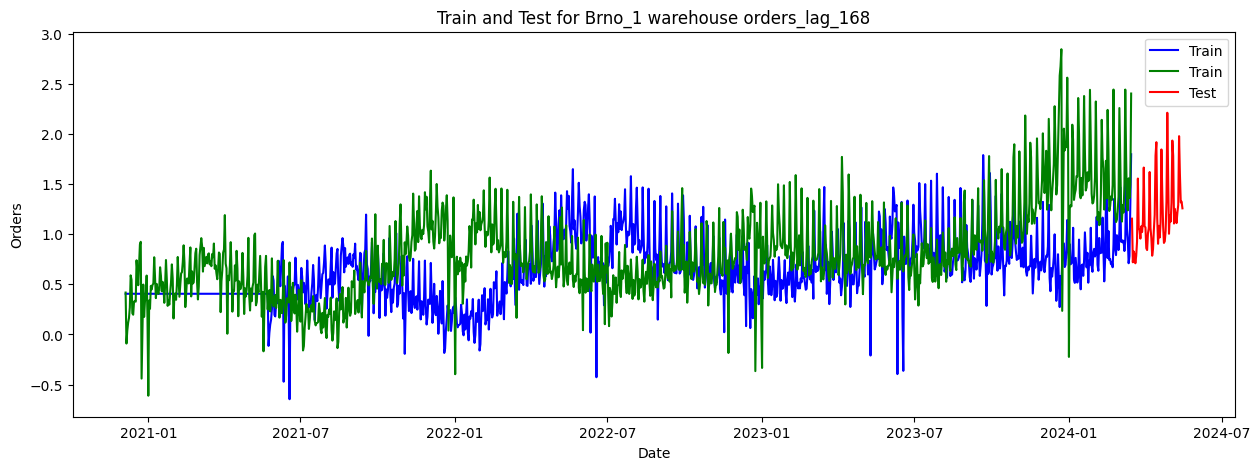

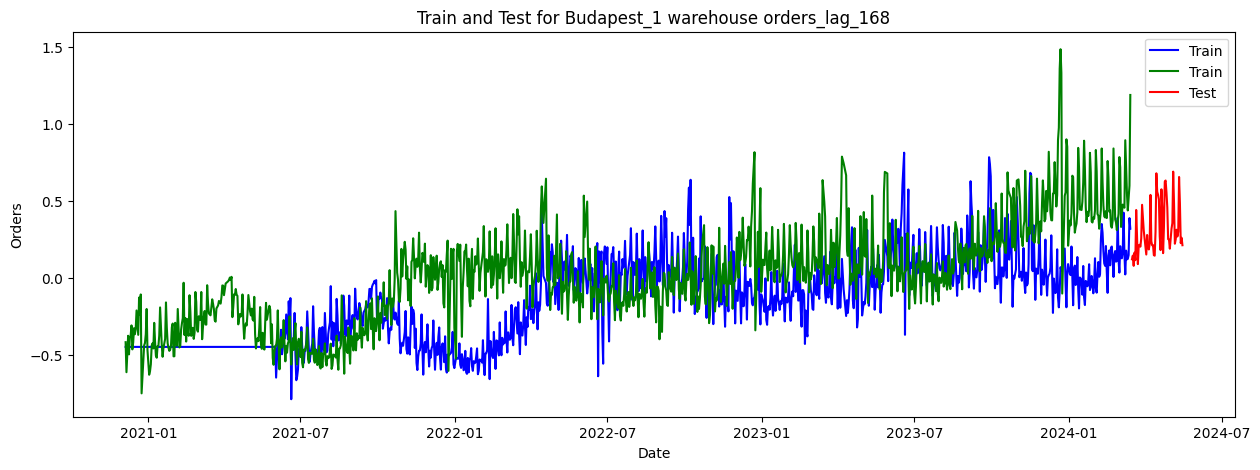

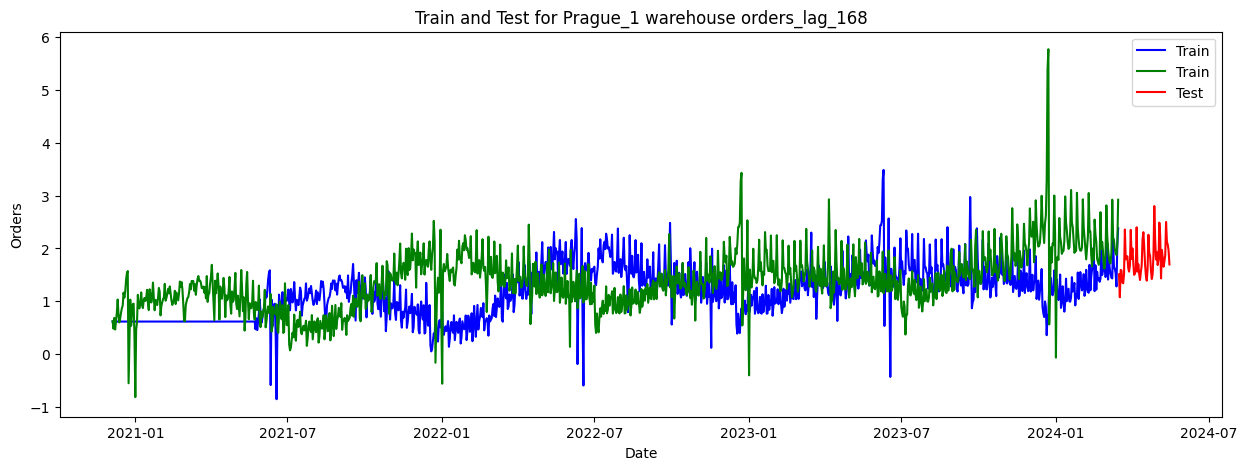

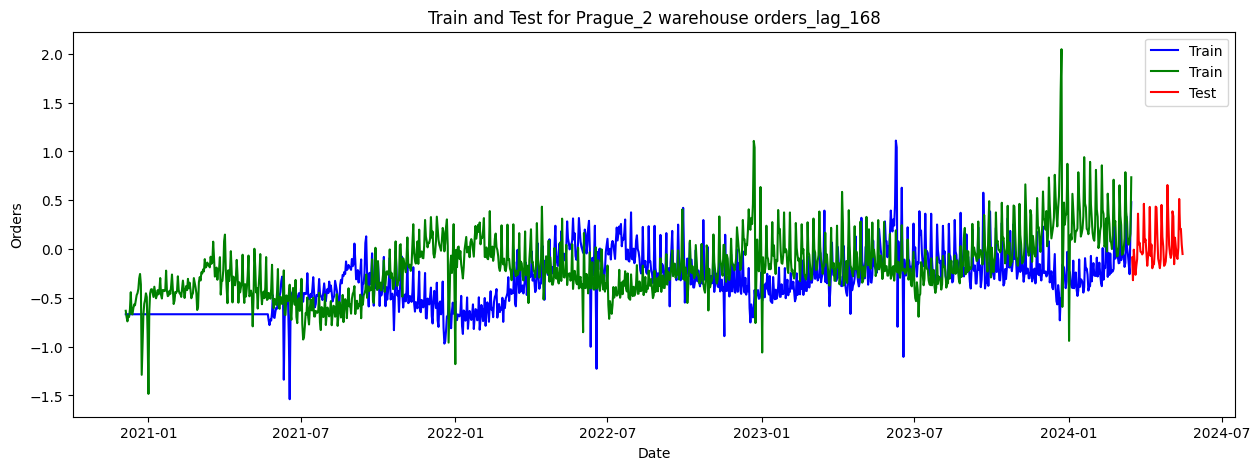

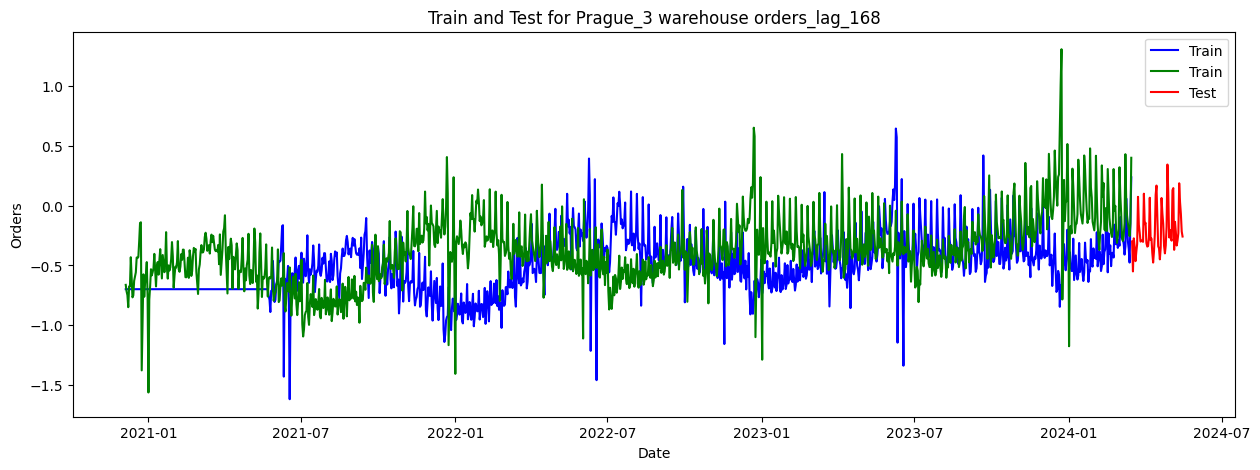

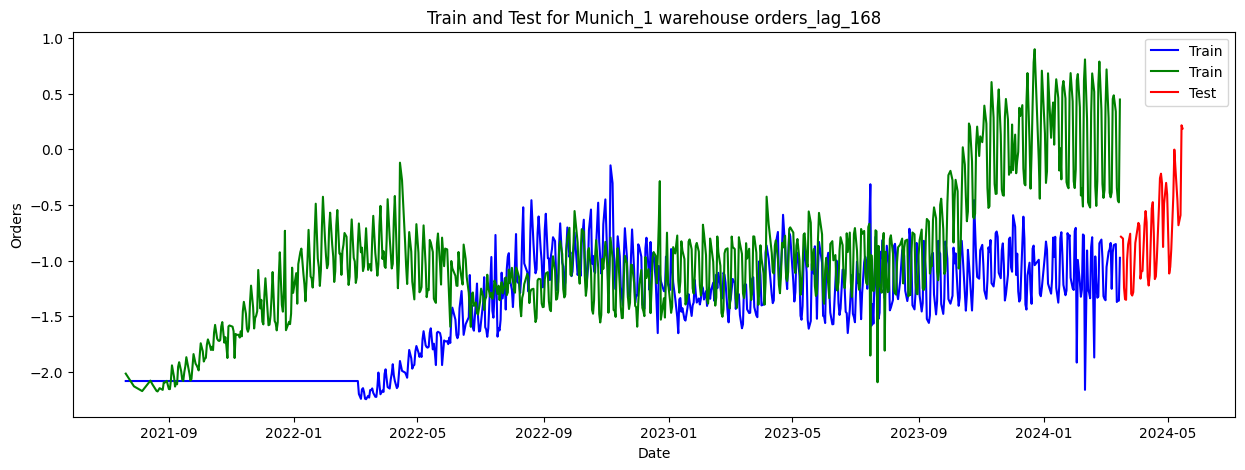

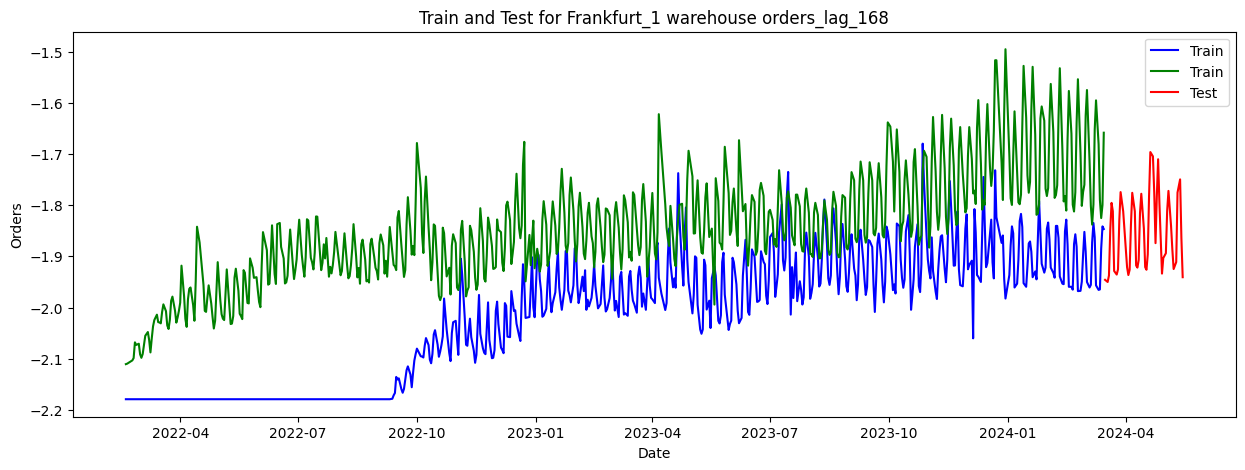

In [34]:
# plot the train and test datasets and visualise them in diferent colors for only column of every warehouse
feature = f'orders_lag_{LAG_DAYS[2]}' # third lag feature for test data

for warehouse in train_df['warehouse'].unique():
    plt.figure(figsize=(15, 5)) 
    datax = processed_train_df[processed_train_df['warehouse'] == warehouse]
    datax_test = processed_test_df[processed_test_df['warehouse'] == warehouse]
    plt.plot(datax.index, datax[feature], label='Train', color='blue')
    plt.plot(datax.index, datax['orders'], label='Train', color='green')
    plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')
    plt.title(f'Train and Test for {warehouse} warehouse {feature}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

In [35]:
print("Start Date:", processed_train_df.index.min())
print("End Date:", processed_train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


## Training Loop

In [36]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [37]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [38]:
def plot_loss(history, warehouse):
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    
    # Highlight the minimum validation loss
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
    plt.axvline(min_val_loss_epoch, linestyle='--', color='gray', linewidth=1)
    plt.text(min_val_loss_epoch, min_val_loss, f'Min Val Loss: {min_val_loss:.4f}', 
             verticalalignment='bottom', horizontalalignment='right', color='gray', fontsize=10)
    
    # Titles and labels
    plt.title(f'Training and Validation Loss for Warehouse: {warehouse}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Set plot styles
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'training_validation_loss_{warehouse}.png', dpi=300)
    
    # Show plot
    plt.show()

In [39]:
"""
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
"""

"\ndef plot_loss(history):\n    plt.figure(figsize=(10, 6))\n    plt.plot(history.history['loss'], label='Training Loss')\n    plt.plot(history.history['val_loss'], label='Validation Loss')\n    plt.title(f'Training and Validation Loss of {warehouse}')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.legend()\n    plt.show()\n"

In [40]:
print(processed_train_df.isna().sum())

day_cos                    0
year_cos                   0
days_since_start           0
year_sin                   0
day_of_year                0
month_sin                  0
month                      0
month_cos                  0
day_sin                    0
day                        0
orders_lag_56              0
orders_lag_84              0
orders_lag_168             0
orders_lag_364             0
orders_rolling_mean_56     0
orders_rolling_std_56      0
orders_rolling_mean_168    0
orders_rolling_std_168     0
orders_rolling_mean_364    0
orders_rolling_std_364     0
day_of_week_0              0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
quarter_1                  0
quarter_2                  0
quarter_3                  0
quarter_4                  0
year_2020                  0
year_2021                  0
year_2022                  0
year_2023     

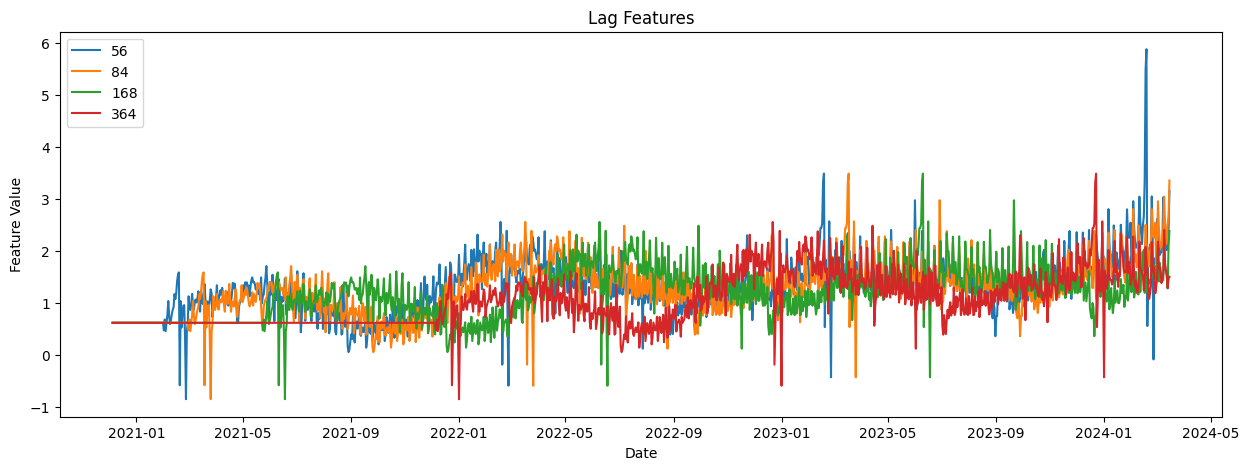

In [41]:
warehouse = 'Prague_1'

#Plot x_train lag feeatures
plt.figure(figsize=(15, 5))
for feature in LAG_DAYS:
    plt.plot(processed_train_data_dict[warehouse][0].index, processed_train_data_dict[warehouse][0][f'orders_lag_{feature}'], label=feature)
plt.title("Lag Features")
plt.xlabel("Date")
plt.ylabel("Feature Value")
plt.legend()
plt.show()


In [42]:
processed_train_data_dict['Prague_1'][0].head()

day_cos  year_cos  days_since_start  year_sin  day_of_year  \
date                                                                      
2020-12-05 -1.219823 -2.236436         -1.872861 -0.316352     1.528528   
2020-12-06 -1.105637 -2.236436         -1.870029 -0.316352     1.537783   
2020-12-07 -0.991450 -2.236436         -1.867197 -0.316352     1.547038   
2020-12-08 -0.877263 -2.236436         -1.864365 -0.316352     1.556293   
2020-12-09 -0.763076 -2.236436         -1.861534 -0.316352     1.565549   

            month_sin     month  month_cos   day_sin       day  orders_lag_56  \
date                                                                            
2020-12-05  -0.614445  1.623779   1.623779  0.517737 -1.219823       0.615804   
2020-12-06  -0.614445  1.623779   1.623779  0.501771 -1.105637       0.615804   
2020-12-07  -0.614445  1.623779   1.623779  0.482902 -0.991450       0.615804   
2020-12-08  -0.614445  1.623779   1.623779  0.461129 -0.877263       0.615804   
2020-12-09  -0.614445  1.623779   1.623779  0.436454 -0.763076       0.615804   

            orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                        
2020-12-05       0.615722        0.615475        0.614899   
2020-12-06       0.615722        0.615475        0.614899   
2020-12-07       0.615722        0.615475        0.614899   
2020-12-08       0.615722        0.615475        0.614899   
2020-12-09       0.615722        0.615475        0.614899   

            orders_rolling_mean_56  orders_rolling_std_56  \
date                                                        
2020-12-05                2.315528              -3.520342   
2020-12-06                2.042293              -3.520342   
2020-12-07                2.212443              -3.503159   
2020-12-08                2.086661              -3.490289   
2020-12-09                2.137706              -3.532100   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                 2.423899               -3.826505   
2020-12-06                 2.139498               -3.826505   
2020-12-07                 2.316601               -3.807994   
2020-12-08                 2.185679               -3.794130   
2020-12-09                 2.238810               -3.839172   

            orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
date                                                                         
2020-12-05                 2.577192               -4.557787            0.0   
2020-12-06                 2.277633               -4.557787            0.0   
2020-12-07                 2.464175               -4.536223            1.0   
2020-12-08                 2.326275               -4.520072            0.0   
2020-12-09                 2.382238               -4.572542            0.0   

            day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
date                                                                     
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-06            0.0            0.0            0.0            0.0   
2020-12-07            0.0            0.0            0.0            0.0   
2020-12-08            1.0            0.0            0.0            0.0   
2020-12-09            0.0            1.0            0.0            0.0   

            day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  \
date                                                                        
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-06            0.0            1.0        0.0        0.0        0.0   
2020-12-07            0.0            0.0        0.0        0.0        0.0   
2020-12-08            0.0            0.0        0.0        0.0        0.0   
2020-12-09            0.0            0.0        0.0        0.0        0.0   

            qua

Training model for warehouse: Brno_1
final shape: ((1137, 56, 41), (1137, 1))
Epoch 1/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6895
Epoch 1: val_loss improved from inf to 0.70827, saving model to model_Brno_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.6608 - val_loss: 0.7083
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8518
Epoch 2: val_loss improved from 0.70827 to 0.53148, saving model to model_Brno_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.8504 - val_loss: 0.5315
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6887
Epoch 3: val_loss improved from 0.53148 to 0.32550, saving model to model_Brno_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6862 - val_loss: 0.3255
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5345
Epoch 4: val_loss improved from 0.32550 to 0.22891, saving model to model_Brno_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5337 - val_loss: 0.2289
Epoch 5/100
29

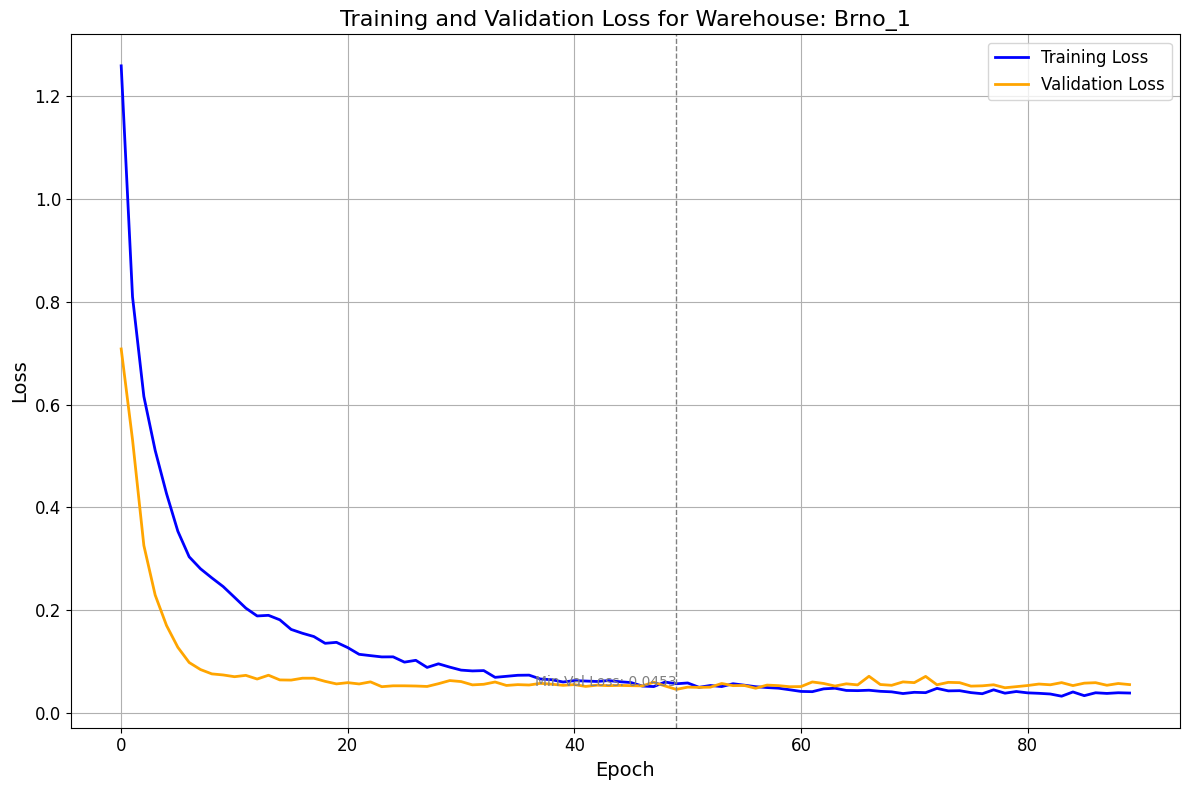

Training model for warehouse: Budapest_1
final shape: ((1098, 56, 41), (1098, 1))
Epoch 1/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9919
Epoch 1: val_loss improved from inf to 0.14049, saving model to model_Budapest_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.9757 - val_loss: 0.1405
Epoch 2/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4228
Epoch 2: val_loss improved from 0.14049 to 0.08056, saving model to model_Budapest_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4217 - val_loss: 0.0806
Epoch 3/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3723
Epoch 3: val_loss improved from 0.08056 to 0.07125, saving model to model_Budapest_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3718 - val_loss: 0.0712
Epoch 4/100
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3034
Epoch 4: val_loss improved from 0.07125 to 0.06114, saving model to model_Budapest_1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3037 - val_loss: 0

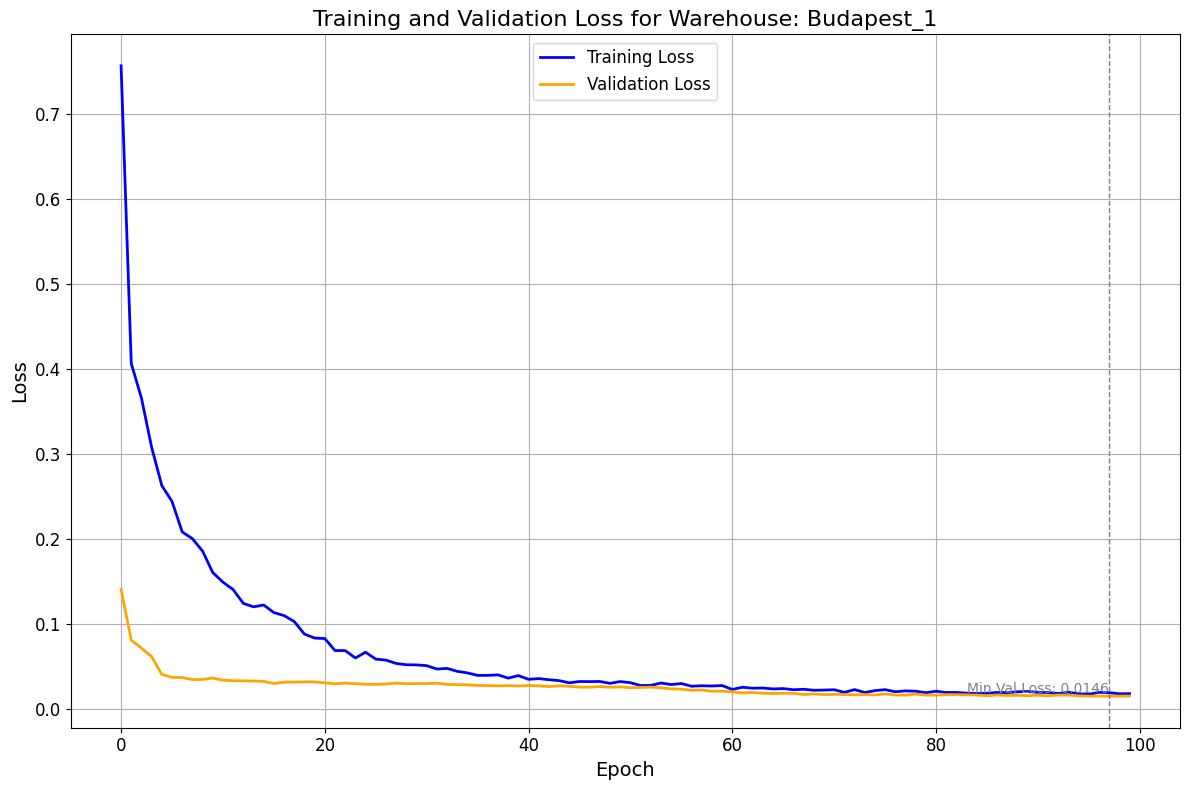

Training model for warehouse: Prague_1
final shape: ((1137, 56, 41), (1137, 1))
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1538
Epoch 1: val_loss improved from inf to 2.59658, saving model to model_Prague_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 3.1401 - val_loss: 2.5966
Epoch 2/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.1670
Epoch 2: val_loss improved from 2.59658 to 2.02364, saving model to model_Prague_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 2.1636 - val_loss: 2.0236
Epoch 3/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.7149
Epoch 3: val_loss improved from 2.02364 to 1.48341, saving model to model_Prague_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.7111 - val_loss: 1.4834
Epoch 4/100
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4939
Epoch 4: val_loss improved from 1.48341 to 1.06430, saving model to model_Prague_1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.4832 - val_loss: 1.0643
Epoc

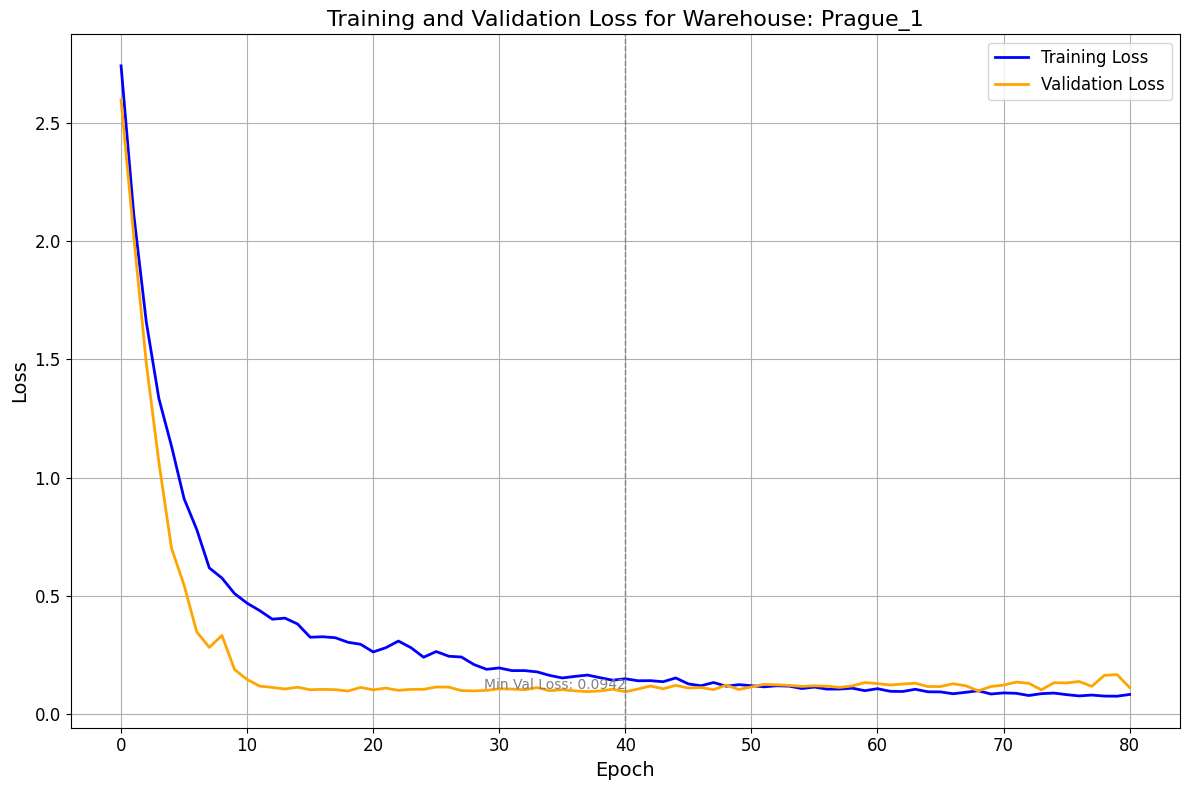

Training model for warehouse: Prague_2
final shape: ((1137, 56, 41), (1137, 1))
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9458
Epoch 1: val_loss improved from inf to 0.08820, saving model to model_Prague_2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.9386 - val_loss: 0.0882
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4963
Epoch 2: val_loss improved from 0.08820 to 0.06618, saving model to model_Prague_2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4958 - val_loss: 0.0662
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4245
Epoch 3: val_loss did not improve from 0.06618
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4236 - val_loss: 0.0799
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3562
Epoch 4: val_loss did not improve from 0.06618
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.3565 - val_loss: 0.0737
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3611
Epoch 5: val_loss imp

Training model for warehouse: Prague_3
final shape: ((1137, 56, 41), (1137, 1))
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.3241
Epoch 1: val_loss improved from inf to 0.05686, saving model to model_Prague_3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 1.3149 - val_loss: 0.0569
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6475
Epoch 2: val_loss did not improve from 0.05686
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6464 - val_loss: 0.0624
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4857
Epoch 3: val_loss did not improve from 0.05686
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4858 - val_loss: 0.0583
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4159
Epoch 4: val_loss improved from 0.05686 to 0.05438, saving model to model_Prague_3.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.4161 - val_loss: 0.0544
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3702
Epoch 5: val_loss imp

Training model for warehouse: Munich_1
final shape: ((729, 56, 41), (729, 1))
Epoch 1/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2901
Epoch 1: val_loss improved from inf to 1.14070, saving model to model_Munich_1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 2.2430 - val_loss: 1.1407
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2029
Epoch 2: val_loss improved from 1.14070 to 0.77033, saving model to model_Munich_1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.2010 - val_loss: 0.7703
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9982
Epoch 3: val_loss improved from 0.77033 to 0.57907, saving model to model_Munich_1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9959 - val_loss: 0.5791
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.8836
Epoch 4: val_loss improved from 0.57907 to 0.42494, saving model to model_Munich_1.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.8806 - val_loss: 0.4249
Epoch 

Training model for warehouse: Frankfurt_1
final shape: ((573, 56, 41), (573, 1))
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 4.5010
Epoch 1: val_loss improved from inf to 2.76421, saving model to model_Frankfurt_1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 4.4852 - val_loss: 2.7642
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.5730
Epoch 2: val_loss improved from 2.76421 to 2.69644, saving model to model_Frankfurt_1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.5680 - val_loss: 2.6964
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.2439
Epoch 3: val_loss improved from 2.69644 to 2.55579, saving model to model_Frankfurt_1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.2418 - val_loss: 2.5558
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.8921
Epoch 4: val_loss improved from 2.55579 to 2.39274, saving model to model_Frankfurt_1.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.8923 - val_loss

Training complete for all warehouses.


In [43]:
# Training loop
val_data = {}

for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Training model for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse'])
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    # Save the val data in the "val_data" dictionary for each warehouse
    val_data[warehouse] = (X_val, y_val)
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history, warehouse)

print("Training complete for all warehouses.")

In [44]:
# Save all scaler features into a single json scaler config file
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': X_train_scaled.columns.tolist()
}

# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

## MAPE Eval

### Visualize predictions on the training data

Predicting for warehouse: Brno_1
final shape: ((1137, 56, 41), (1137, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step



Mean Absolute Percentage Error on training data for Brno_1: 3.6086%
Predicting for warehouse: Budapest_1
final shape: ((1098, 56, 41), (1098, 1))
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step



Mean Absolute Percentage Error on training data for Budapest_1: 2.7814%
Predicting for warehouse: Prague_1
final shape: ((1137, 56, 41), (1137, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


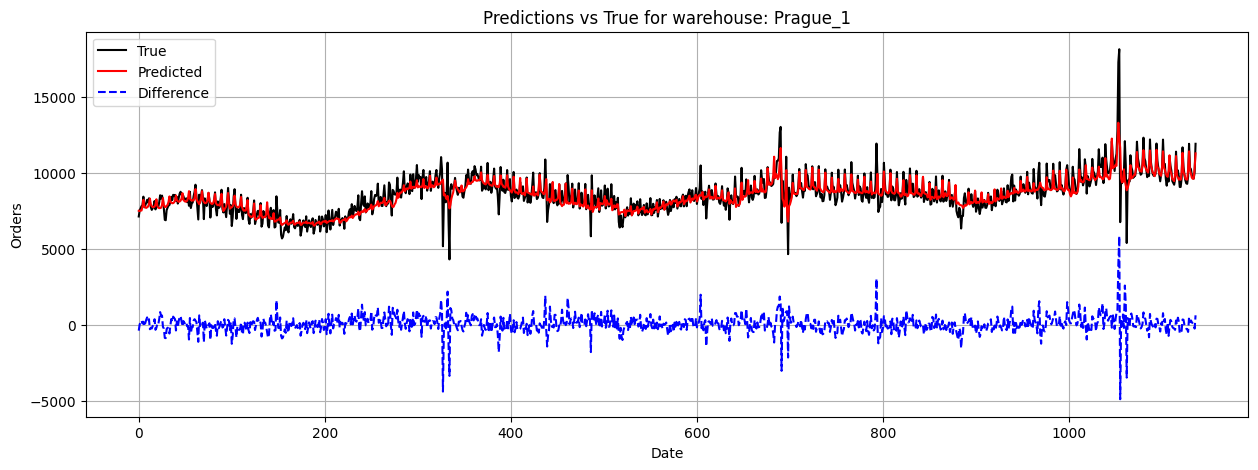


Mean Absolute Percentage Error on training data for Prague_1: 4.5439%
Predicting for warehouse: Prague_2
final shape: ((1137, 56, 41), (1137, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


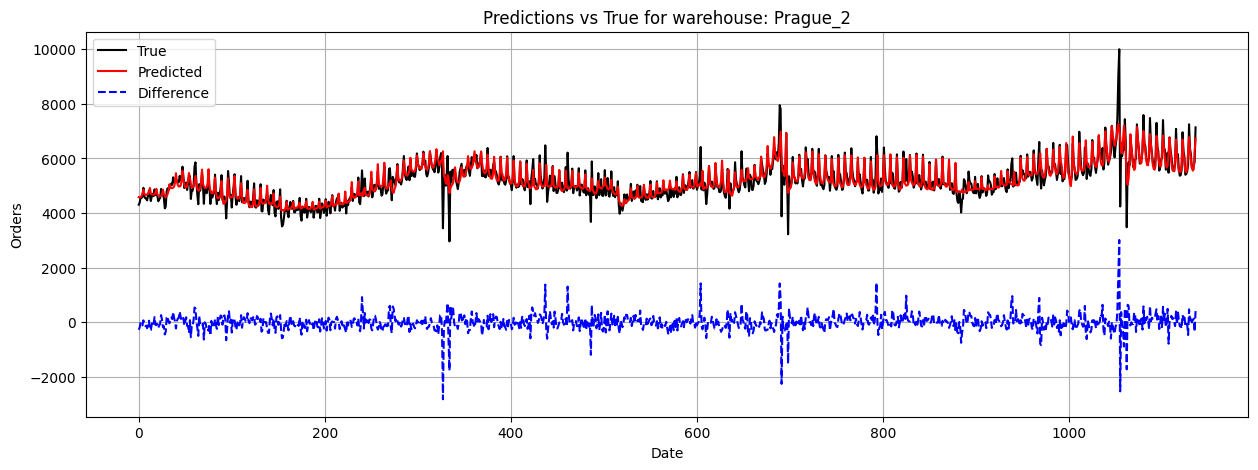


Mean Absolute Percentage Error on training data for Prague_2: 3.8365%
Predicting for warehouse: Prague_3
final shape: ((1137, 56, 41), (1137, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


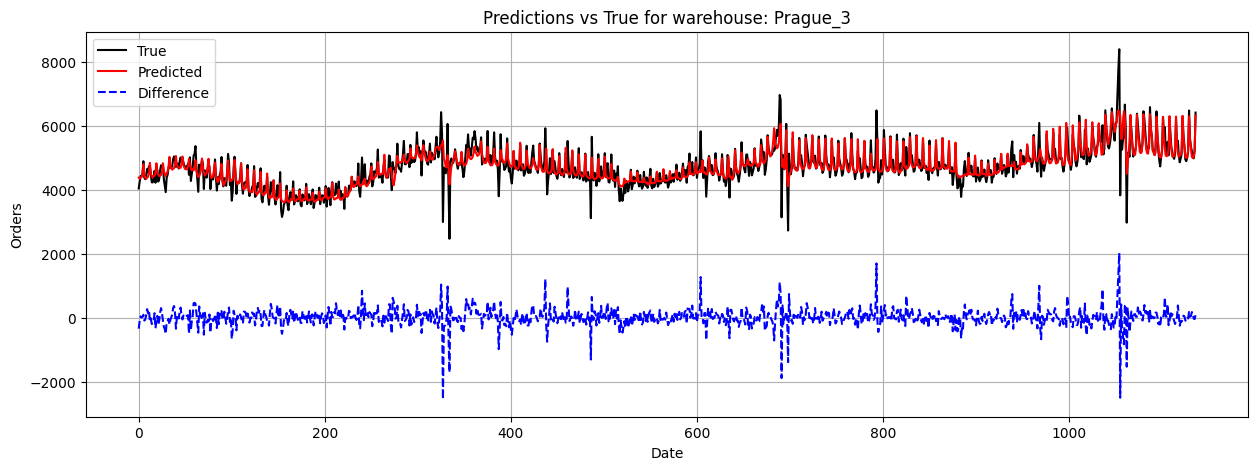


Mean Absolute Percentage Error on training data for Prague_3: 3.8507%
Predicting for warehouse: Munich_1
final shape: ((729, 56, 41), (729, 1))
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


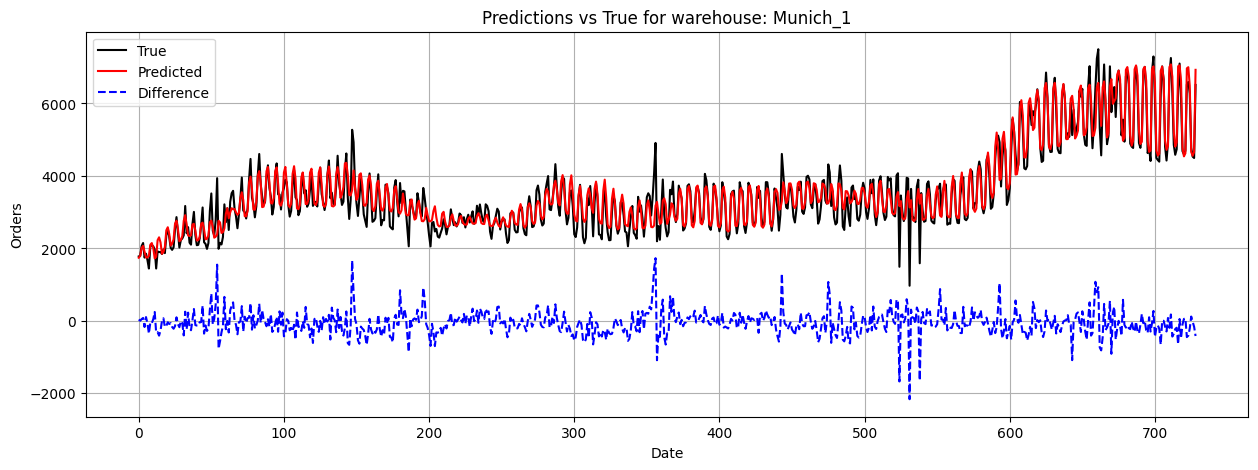


Mean Absolute Percentage Error on training data for Munich_1: 7.7302%
Predicting for warehouse: Frankfurt_1
final shape: ((573, 56, 41), (573, 1))
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


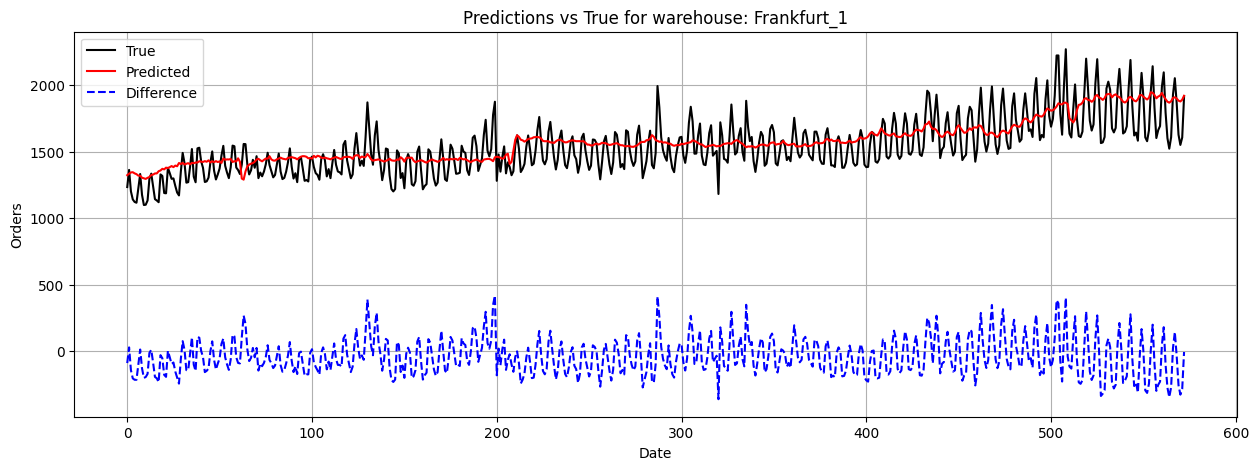


Mean Absolute Percentage Error on training data for Frankfurt_1: 7.9750%

MAPE training scores: 
Brno_1: 3.6086%
Budapest_1: 2.7814%
Prague_1: 4.5439%
Prague_2: 3.8365%
Prague_3: 3.8507%
Munich_1: 7.7302%
Frankfurt_1: 7.9750%

Mean training MAPE: 4.9038%


In [45]:
# Load scalers
y_scaler = joblib.load('y_scaler.joblib')

# Initialize a list to store MAPE scores
mape_scores = []

# Loop through each warehouse and calculate MAPE
for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Predicting for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse'])

    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)

    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')

    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)

    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'\nMean Absolute Percentage Error on training data for {warehouse}: {mape:.4f}%')

# Print MAPE scores
print("\nMAPE training scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean training MAPE: {np.mean(mape_scores):.4f}%")

### Visualize predictions on the validation data

Predicting for warehouse: Brno_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


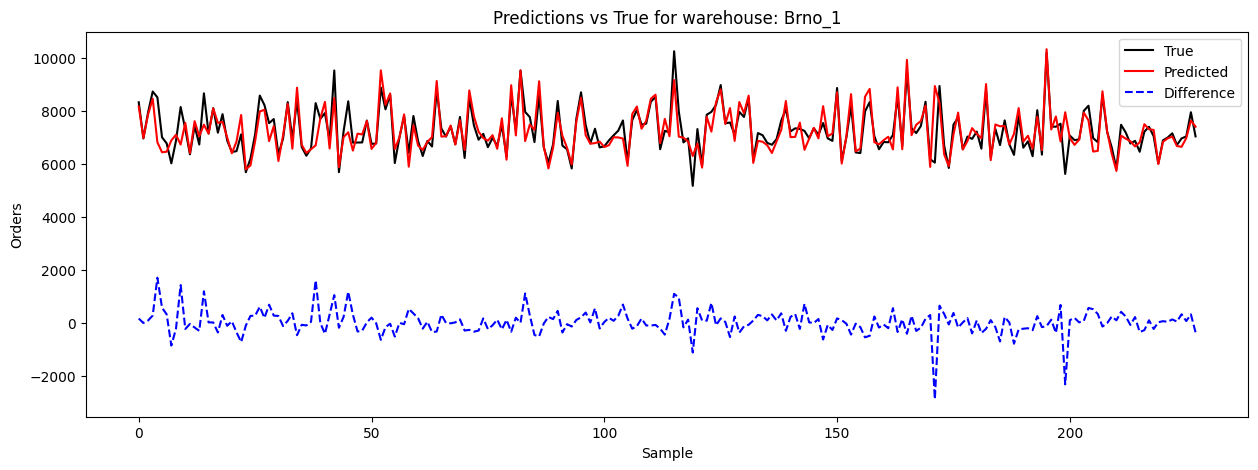


Mean Absolute Percentage Error on validation data for Brno_1: 4.1720%
Predicting for warehouse: Budapest_1
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


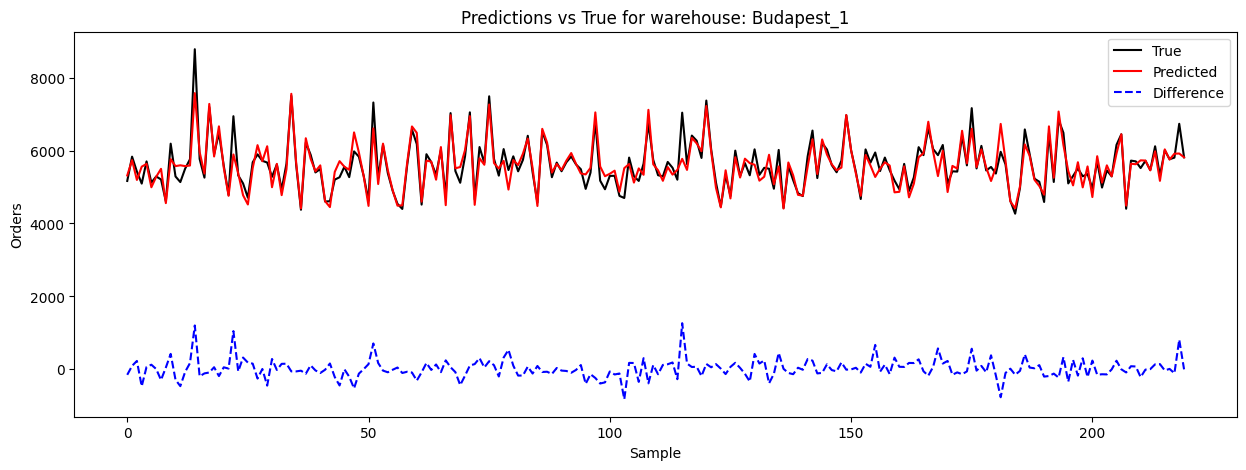


Mean Absolute Percentage Error on validation data for Budapest_1: 3.1676%
Predicting for warehouse: Prague_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


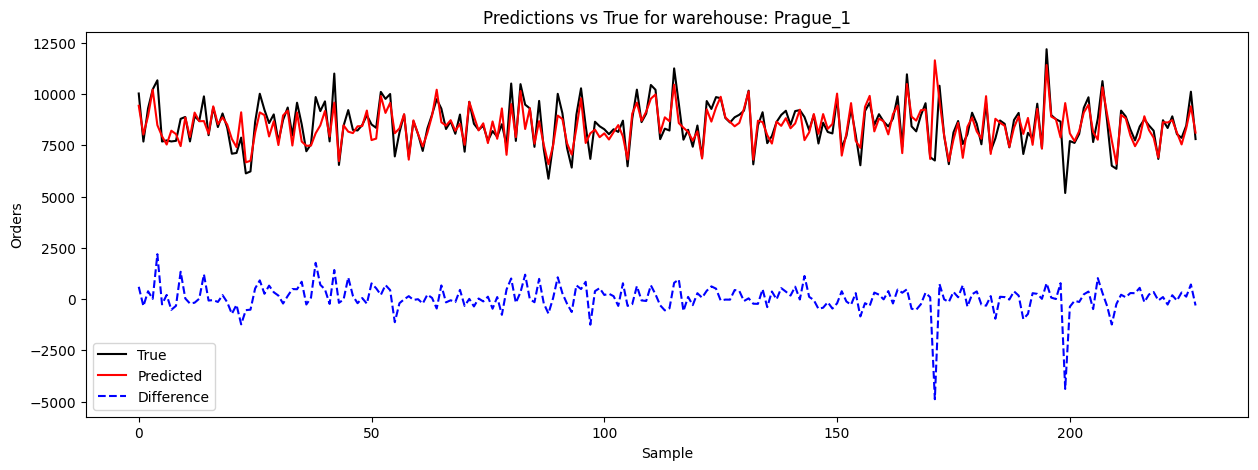


Mean Absolute Percentage Error on validation data for Prague_1: 5.1323%
Predicting for warehouse: Prague_2
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step



Mean Absolute Percentage Error on validation data for Prague_2: 4.2959%
Predicting for warehouse: Prague_3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


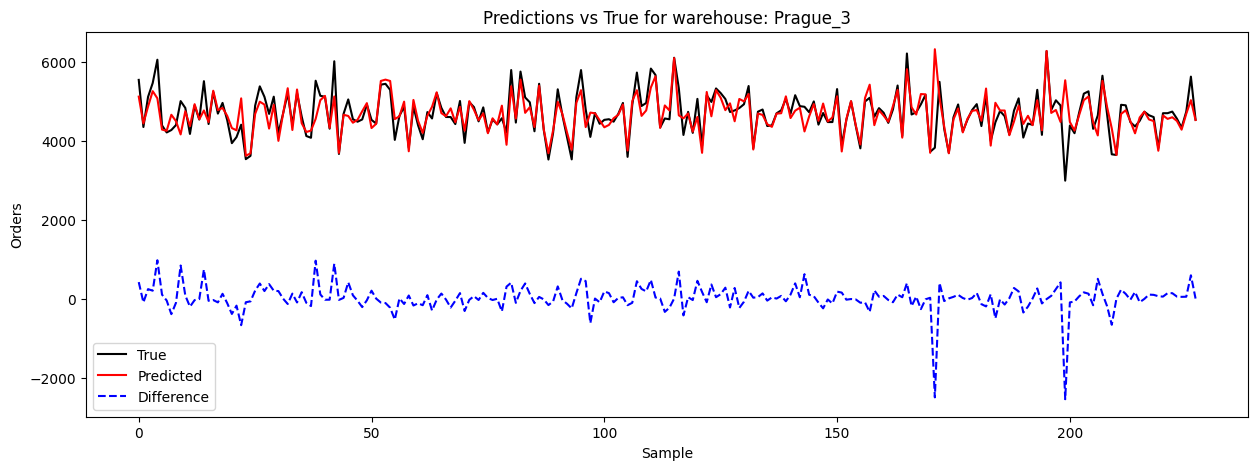


Mean Absolute Percentage Error on validation data for Prague_3: 4.2350%
Predicting for warehouse: Munich_1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step



Mean Absolute Percentage Error on validation data for Munich_1: 8.2751%
Predicting for warehouse: Frankfurt_1
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


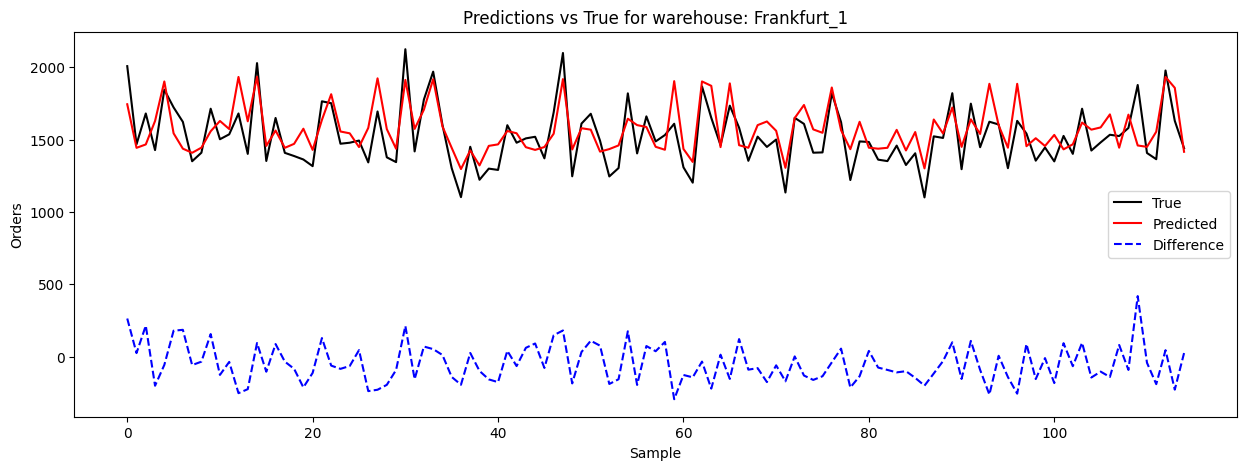


Mean Absolute Percentage Error on validation data for Frankfurt_1: 8.1457%

MAPE validation scores: 
Brno_1: 4.1720%
Budapest_1: 3.1676%
Prague_1: 5.1323%
Prague_2: 4.2959%
Prague_3: 4.2350%
Munich_1: 8.2751%
Frankfurt_1: 8.1457%

Mean validation MAPE: 5.3462%


In [46]:
mape_scores = []
y_scaler = joblib.load('y_scaler.joblib')

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    # Load the validation data for the current warehouse
    X_val, y_val = val_data[warehouse]
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_val)
    predictions = y_scaler.inverse_transform(predictions)
    y_val_unscaled = y_scaler.inverse_transform(y_val)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_val_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on validation data for {warehouse}: {mape:.4f}%')

print("\nMAPE validation scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean validation MAPE: {np.mean(mape_scores):.4f}%")

## Inference and visualisation on test data:

In [47]:

def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)


In [48]:
def predict_multiple(data, time_steps, warehouse_models, y_scaler, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouse_models:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue

        model = warehouse_models[warehouse]
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features)

        sequences = create_sequences(wh_data, time_steps)
        
        # how many sequences and what shape ?
        print(f"sequences shape: {sequences.shape}")
        
        
        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)
        
        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)
        
        # Adjust predictions based on time_steps
        if time_steps > 1:
            # We only keep the last prediction for each sequence
            preds_rescaled = preds_rescaled[:, -1]
        
        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)
        
        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()
        wh_submission_data['predicted_orders'] = wh_predictions
        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)
    return np.array(predictions), submission_df

In [49]:
def load_models_and_scalers(warehouses):
    warehouse_models = {}
    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}.keras')
            warehouse_models[wh] = model
        except Exception as e:
            print(f"Error loading model for warehouse {wh}: {str(e)}")
    return warehouse_models

In [50]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
dataframe.head()
print(f"Rows: {len(dataframe)}")

Rows: 397


In [51]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib') # load the scaler config
ohsc = joblib.load("onehot_scaler.joblib")   # OneHotEncoder for categorical features

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 10


In [52]:
id = dataframe['id']
date = dataframe['date']
warehouse = dataframe["warehouse"]

In [53]:
processed_data = preprocess_data(dataframe, categorical_features, x_scaler_features, binary_features, inference=True)
processed_data = pd.concat([warehouse, processed_data], axis=1)
processed_data = processed_data.set_index(dataframe.date)
len(processed_data.columns)

KeyError: "None of [Index(['day_of_week', 'quarter', 'year'], dtype='object')] are in the [columns]"

In [ ]:
# Load models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = load_models_and_scalers(warehouses)
y_scaler = joblib.load('y_scaler.joblib')

In [ ]:
predictions, submission_df = predict_multiple(processed_data, TIME_STEPS, warehouse_models, y_scaler, training_features)

sequences shape: (61, 56, 41)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


In [ ]:
# Align 'id' and 'date' with the original dataframe
dataframe = dataframe.set_index('date')
submission_df['id'] = submission_df.index.map(lambda x: dataframe.loc[x, 'id'] if x in dataframe.index else np.nan)
submission_df['date'] = submission_df.index

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [ ]:
len(submission_df.predicted_orders)

61

In [ ]:
submission_df.tail()

warehouse  day_of_year  orders_lag_364  year_sin  days_since_start  \
date                                                                            
2024-05-11  Prague_1    -0.411082        1.180259  1.381981          1.896546   
2024-05-12  Prague_1    -0.401975        0.812003  1.381981          1.899442   
2024-05-13  Prague_1    -0.392868        0.793462  1.381981          1.902338   
2024-05-14  Prague_1    -0.383762        0.922737  1.381981          1.905234   
2024-05-15  Prague_1    -0.374655        0.695861  1.381981          1.908130   

            orders_rolling_std_56  orders_rolling_mean_364  \
date                                                         
2024-05-11              -2.419379                 2.136972   
2024-05-12              -2.419379                 2.139909   
2024-05-13              -2.419379                 2.143314   
2024-05-14              -2.419379                 2.143592   
2024-05-15              -2.419379                 2.149419   

            orders_rolling_mean_56  month_sin  month_cos  orders_lag_168  \
date                                                                       
2024-05-11                -9.37255   0.463266  -0.371314        1.254327   
2024-05-12                -9.37255   0.463266  -0.371314        0.989632   
2024-05-13                -9.37255   0.463266  -0.371314        0.951347   
2024-05-14                -9.37255   0.463266  -0.371314        0.871807   
2024-05-15                -9.37255   0.463266  -0.371314        0.687643   

             day_sin     month  year_cos  orders_lag_56  orders_lag_84  \
date                                                                     
2024-05-11 -0.091071 -0.371314  1.975888      -3.793497       1.122771   
2024-05-12  0.340329 -0.371314  1.975888      -3.793497       0.984860   
2024-05-13  0.853345 -0.371314  1.975888      -3.793497       0.694368   
2024-05-14  0.264571 -0.371314  1.975888      -3.793497       0.641551   
2024-05-15 -0.411645 -0.371314  1.975888      -3.793497       0.592926   

            orders_rolling_std_364  orders_rolling_std_168       day  \
date                                                                   
2024-05-11                2.369975                2.715946 -0.528088   
2024-05-12                2.381332                2.747077 -0.414121   
2024-05-13                2.392187                2.777467 -0.300154   
2024-05-14                2.405310                2.804390 -0.186187   
2024-05-15                2.412070                2.815135 -0.072220   

             day_cos  orders_rolling_mean_168  day_of_week_0  day_of_week_1  \
date                                                                          
2024-05-11 -0.528088                 2.926548            0.0            0.0   
2024-05-12 -0.414121                 2.929778            0.0            0.0   
2024-05-13 -0.300154                 2.934602            1.0            0.0   
2024-05-14 -0.186187                 2.942735            0.0            1.0   
2024-05-15 -0.072220                 2.958546            0.0            0.0   

            day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  \
date                                                                     
2024-05-11            0.0            0.0            0.0            1.0   
2024-05-12            0.0            0.0            0.0            0.0   
2024-05-13            0.0            0.0            0.0            0.0   
2024-05-14            0.0            0.0            0.0            0.0   
2024-05-15            1.0            0.0            0.0            0.0   

            day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  \
date                                                                    
2024-05-11            0.0        0.0        1.0        0.0        0.0   
2024-05-12            1.0        0.0        1.0        0.0        0.0   
2024-05-13            0.0        0.0        1.0        0.0        0.0   
2024-05-14   

In [ ]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("data/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))
    
    plt.plot(wh_df_pred.index, wh_df_pred['predicted_orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")

Predictions complete. Submission file and plots created.
